<a href="https://colab.research.google.com/github/adalbertii/Modele-regresyjne/blob/main/mpg-case-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wykorzystanie danych  [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg).

[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


Demonstracja sposobu budowania modelu przeznaczonego do predykcji efektywnosci spalania paliwa.

Tok działania:
- pobranie danych i ich wstępna analiza
- uproszczona standaryzacja danych
- budowa modelu opratego na jednym neuronie i jednym atrybucie (zmiennej objaśnijającej)
- budowa modelu składającego się z jednego neurona i wykorzystującego wszystkie zmienne objaśniajace
- budowa modelu składajacego się z 64 neuronó i jednej zmiennej objaśniajacej
-budowa modelu 64 neronowego ze wsystkimi zmiennymi objaśniajacymi

In [28]:
!pip install -q seaborn

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


np.set_printoptions(precision=3, suppress=True)

In [30]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.13.0


### Pobranie danych do uczenia modelu
Wykorzystanie modułu pandas


In [31]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Liczba cylindrow', 'Pojemność skokowa', 'Moc', 'Waga',
                'Przyspieszenie', 'Rok modelu', 'Pochodzenie']
# mpg - miles per gallon
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [32]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Pochodzenie
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [33]:
dataset.head(20)

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Pochodzenie
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
5,15.0,8,429.0,198.0,4341.0,10.0,70,1
6,14.0,8,454.0,220.0,4354.0,9.0,70,1
7,14.0,8,440.0,215.0,4312.0,8.5,70,1
8,14.0,8,455.0,225.0,4425.0,10.0,70,1
9,15.0,8,390.0,190.0,3850.0,8.5,70,1


In [34]:
## sprawdzamy charakterystykę atrybutów
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MPG                398 non-null    float64
 1   Liczba cylindrow   398 non-null    int64  
 2   Pojemność skokowa  398 non-null    float64
 3   Moc                392 non-null    float64
 4   Waga               398 non-null    float64
 5   Przyspieszenie     398 non-null    float64
 6   Rok modelu         398 non-null    int64  
 7   Pochodzenie        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [35]:
dataset.describe()

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Pochodzenie
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [36]:
dataset.corr()['MPG'].sort_values(ascending=False)


MPG                  1.000000
Rok modelu           0.579267
Pochodzenie          0.563450
Przyspieszenie       0.420289
Liczba cylindrow    -0.775396
Moc                 -0.778427
Pojemność skokowa   -0.804203
Waga                -0.831741
Name: MPG, dtype: float64

In [37]:
import plotly.express as px

In [38]:

#px.histogram(dataset, width=1400, height=800, nbins=50)

px.histogram(dataset, x='MPG', width=1000, height=400, nbins=50, facet_col='Pochodzenie')

In [39]:
px.histogram(dataset, x='MPG', width=1000, height=400, nbins=50, facet_col='Liczba cylindrow')

In [40]:
px.histogram(dataset, x='Rok modelu', width=1000, height=400, nbins=50)

### Wstępne przygotowanie danych




In [41]:
# sprawdzamy czy występują braki danych
dataset.isna().sum()

MPG                  0
Liczba cylindrow     0
Pojemność skokowa    0
Moc                  6
Waga                 0
Przyspieszenie       0
Rok modelu           0
Pochodzenie          0
dtype: int64

Istnieją braki danych.
Dla uproszczenia usuwamy rekordy zawierajace braki danych

In [42]:
dataset = dataset.dropna()

In [43]:
dataset.isna().sum()

MPG                  0
Liczba cylindrow     0
Pojemność skokowa    0
Moc                  0
Waga                 0
Przyspieszenie       0
Rok modelu           0
Pochodzenie          0
dtype: int64

Kolumna 'Pochodzenie` jet atrybutem kategorycznym, nie numerycznym .
Nalezy zatem przeprowadić na tej kolumnie transfomację "one-hot-encod".
W tym celu wykorzystana zostanie  metoda [pd.get_dummies]

In [44]:
dataset['Pochodzenie'] = dataset['Pochodzenie'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [ ]:
dataset.head(5)

In [45]:
dataset = pd.get_dummies(dataset, columns=['Pochodzenie'], prefix='', prefix_sep='') ###
dataset.tail()

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Podział danych na dane treningowe i testowe

Dane testowe zostaną wykorzystane do końcowej ewaluacji modelu

In [49]:
dataset.shape

(392, 10)

In [46]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [47]:
train_dataset.shape

(314, 10)

In [48]:
test_dataset.shape

(78, 10)

### Wstępna analiza danych



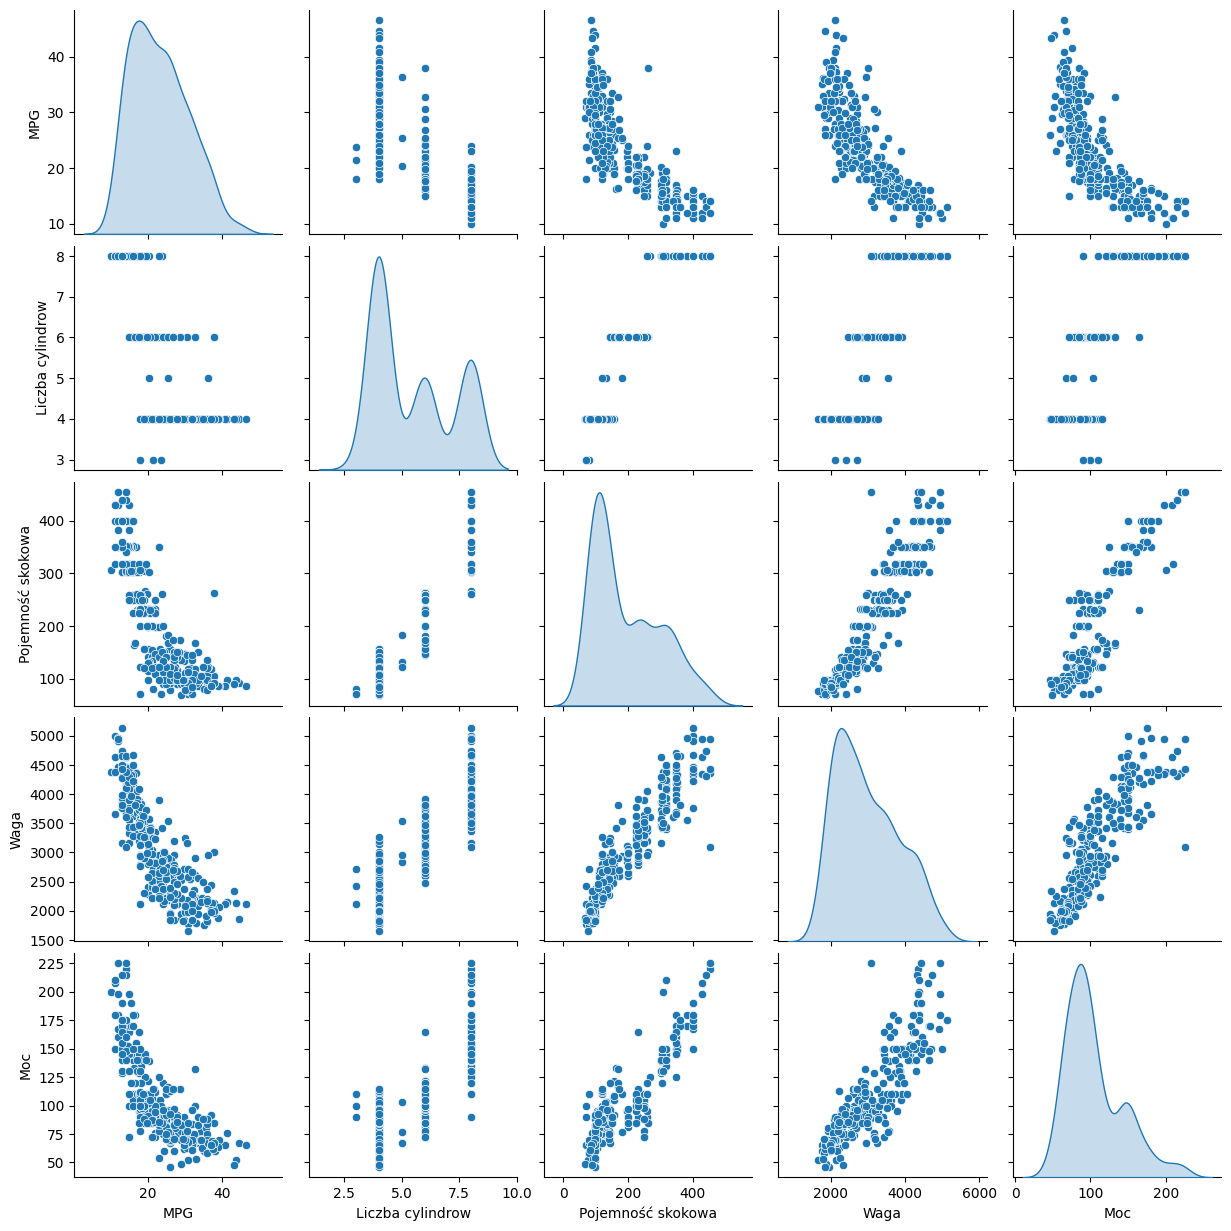

In [50]:
sns.pairplot(train_dataset[['MPG', 'Liczba cylindrow', 'Pojemność skokowa', 'Waga','Moc']], diag_kind='kde')

Weryfikacja rozkładów statystycznych zmiennych objaśniajacych

In [51]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Liczba cylindrow,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Pojemność skokowa,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Moc,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Waga,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Przyspieszenie,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Rok modelu,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Rozdzielenie zmiennych objaśniajacych od zmiennej objaśnianej (etykiety)


In [52]:
# najpierw same cechy (zmienne objaśniajaće)
train_features = train_dataset.copy()
test_features = test_dataset.copy()



In [ ]:
# teraz tzw. etykiety, czyli zmenne objaśniane
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [56]:
train_features.shape

(314, 9)

In [53]:
train_features

,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [57]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

## Normalizacja danych



In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]


Wartość średnia i odchylenie standardowe jest mocno żróżnicowane.

Dobrą praktyką jest normalizacja cech, które używają różnych skal i zakresów.

Jednym z powodów, dla których jest to ważne, jest to, że cechy są mnożone przez wagi modelu. Tak więc skala wyników i skala gradientów zależy od skali danych wejściowych.

Chociaż model *może* uczyć  się bez normalizacji cech, normalizacja sprawia, że szkolenie jest znacznie bardziej stabilne.


### Warstwa normalizująca  dane

Tworzymy instancję normalizatora

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Dokonujemy normalizacji zmiennych objaśniajacych :

In [ ]:
normalizer.adapt(np.array(train_features))

Gdy warstwa jest wywoływana, zwraca dane wejściowe, z każdą cechą niezależnie znormalizowaną:

In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

## Regresja liniowa

Przed zbudowaniem głebokiej sieci neuronowej przeanalizujemu budowę liniowej sieci z jedną i wieloma cechami (zmiennymi objaśniajacymi)

### Regresja lionowa z jedną zmienną objaśniajacą

Predykcja 'MPG' na podstwie zmiennej 'Moc'.

Sieć neuronowa będzie zbudowana z dwóch warstw:

- warstwy normalizującej atrybut wejściowy 'moc` (przy użyciu klasy  `tf.keras.layers.Normalization).
- warstwy Dense

In [ ]:
horsepower = np.array(train_features['Moc'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Budowa modelu Keras

In [ ]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Po zbudowaniu modelu należy go skompilować.

Na tym etapie kluczowy jest dobór hiperparametrów modelu:
*   'loss'
*   'optimizer'



In [ ]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Proces uczenia modelu

In [ ]:
%%time
history = horsepower_model.fit(
    train_features['Moc'],
    train_labels,
    epochs=100,
    verbose=1,
    validation_split = 0.2) #Oblicza wyniki walidacji na 20% danych treningowych

Wizualizacja procesu uczenia przy użyciu statystyk zapisanych w obiekcie `history`.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
horsepower_model.summary()

In [ ]:
# wyznaczone współczynniki wagowe modelu

wagi = horsepower_model.get_weights()
wagi

Zachowanie rezultatów na poźniejsze porównania

In [ ]:
# tworzymy słownik dla oceny wskażników ewaluacyjnych (stopnia dokładności predykcyjnej modelu)
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Moc'], # dane dla jednej zmiennej objaśnijacej
    test_labels, verbose=1) # etykiety dla danych tesowych

In [ ]:
test_results

Ponieważ jest to regresja pojedynczej zmiennej, łatwo jest wyświetlić prognozy modelu jako funkcję danych wejściowych.

In [ ]:
x = tf.linspace(0.0, 250, 251)


In [ ]:
x[:10]

In [ ]:
y = horsepower_model.predict(x)

In [ ]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Moc'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

In [ ]:
plot_horsepower(x, y)

### Regresja liniowa z wieloma zmiennymi objaśniajacymi

Ponownie budujemy dwuetapowy model sekwencyjny Keras z pierwszą warstwą będącą normalizatorem (tf.keras.layers.Normalization(axis=-1)), który zdefiniowaliśmy wcześniej i dostosowali  do całego zbioru danych (wszystkie zmienne objaśniajace)


In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [ ]:
linear_model.summary()

Kompilujemy model i przechodzimy do jego uczenia

In [ ]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features,# wszzystkie zmienne objasniajace
    train_labels,
    epochs=100,
    verbose=1,
    validation_split = 0.2)

Wykorzystując wszystkie zmienne objaśniajace uzyskujemy znacznie niższy błąd treningowy i walidacyjny niż w poprzedniom modelu (`horsepower_model`)

In [ ]:
plot_loss(history)

Zapisujemy wyniki ewaluacji modelu dla danych testowych

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=1)

I porównajmy wskażniki ewaluacyjne dla dwóch modeli  z jedną zmienna objaśniającą i wieloma zmiennymi objasniającymi

In [ ]:
test_results

## Regresja za pomocą sici głębokich [deep neural network (DNN)]


Zaimplementujemy  modele DNN z pojedynczym i wieloma wejściami.

Kod jest zasadniczo taki sam, z wyjątkiem tego, że model jest rozszerzony o niektóre "ukryte" warstwy nieliniowe.

Modele te będą zawierać kilka warstw więcej niż model liniowy:

Liniowa warstwa Dense z pojedynczym wyjściem.


*   Warstwa normalizacji, jak poprzednio (z horsepower_normalizer dla modelu z jednym wejściem i normalizer dla modelu z wieloma wejściami).

*   Dwie ukryte, nieliniowe warstwy Dense z nieliniowością funkcji aktywacji ReLU (relu).
*   Liniowa warstwa Dense z pojedynczym wyjściem.

Oba modele będą korzystać z tej samej procedury uczenia, więc metoda kompilacji jest zawarta w poniższej funkcji build_and_compile_model.

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regresja przy użyciu DNN i pojedynczego wejścia

Zbudujemy model DNN  tylko z `'Moc`` jako danymi wejściowymi i `horsepower_normalizer` (zdefiniowanym wcześniej) jako warstwą normalizacji

In [ ]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

Model ten ma o wiele więcej parametrów do wytrenowania niż modele liniowe

In [ ]:
dnn_horsepower_model.summary()

Proces trenowania modelu (za pomocą metody  Keras `Model.fit`)

In [ ]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Moc'],
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Ten model radzi sobie nieco lepiej niż jednowejściowy  model liniowy `horsepower_model`

In [ ]:
plot_loss(history)

Jeśli wygenerujemy wykres predykcji ajko funkcji zmiennej 'Moc' łatwo zauważyć jak ten model wykorzystuje nieliniowość zapewnianą przez ukryte warstwy:

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


In [ ]:
plot_horsepower(x, y)

Zapisujemy rezultat ewaluacji dla tego modelu (na danych testowych)
Na końcu notebok- a przedstwimy porównaie tego wskażnika dla wszystkich modeli

In [ ]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Moc'], test_labels,
    verbose=0)

### Regresja przy wykorzystaniu modelu DNN i wszystkich zmiennych objaśniajacych

Powtórzymy poprzedni proces, używając wszystkich dane wejściowe. Wydajność modelu nieznacznie poprawia się na zestawie danych walidacyjnych.

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 5.41 s, sys: 174 ms, total: 5.58 s
Wall time: 5.88 s


In [ ]:
plot_loss(history)

Zapisujemy rezultat ewaluacji tego modelu (dla danych testowych)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Porównanie wydajności zbudowanych modeli

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

### Predykcja

Dokonamy teraz predykcji za pomocą `dnn_model` **na zbiorze testowym** używając Keras `Model.predict`

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Wygląda na to, że model przewiduje dość dobrze.

Teraz należy sprawdzić rozkład błędów:

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')